# Restaurant Rating Prediction (1–5)

## EDA + 3 Skenario (TF‑IDF → Transformers → Augmentation Saved-to-CSV)

1. **EDA + preprocessing**
2. **Skenario 1 — Baseline TF‑IDF**
   - SVM
   - Naive Bayes
   - Logistic Regression
3. **Skenario 2 — Baseline Transformers**
   - BERT
   - DistilBERT
   - (dengan Early Stopping ringan)
4. **Skenario 3 — Augmentasi**
   - **Generate & simpan** train augmented ke CSV:
     - EDA
     - Modified EDA
     - BERT augmentation (nlpaug)
     - Backtranslation (opsional, berat)


In [ ]:
# import os
# import importlib
# import sys
# import subprocess

# def install(pkg):
#     subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# # ===========================
# # 🛠 Version Compatibility Fix
# # ===========================

# REQUIRED_PYARROW = "14.0.2"
# REQUIRED_PANDAS = "2.2.2"  # Colab default-compatible
# REQUIRED_DATASETS = "4.4.1"  # Already installed, should stay

# need_restart = False

# def check_and_fix_version(package, required_version):
#     global need_restart
#     try:
#         mod = importlib.import_module(package)
#         current_version = mod.__version__
#         if current_version != required_version:
#             print(f"⚠ {package} mismatch: {current_version} → {required_version}")
#             install(f"{package}=={required_version}")
#             need_restart = True
#         else:
#             print(f"✓ {package} OK: {current_version}")
#     except ImportError:
#         print(f"⚠ {package} not found, installing...")
#         install(f"{package}=={required_version}")
#         need_restart = True

# check_and_fix_version("pyarrow", REQUIRED_PYARROW)
# check_and_fix_version("pandas", REQUIRED_PANDAS)
# check_and_fix_version("datasets", REQUIRED_DATASETS)

# # ==============================
# # 🔄 Restart if anything changed
# # ==============================
# if need_restart:
#     print("\n🔁 Restarting runtime to apply binary changes...")
#     os.kill(os.getpid(), 9)
# else:
#     print("\n🚀 All good! Continue running training code.")


In [ ]:
# pip install -U "datasets>=3.1.0" --upgrade


In [ ]:
# !pip -q install pandas numpy scikit-learn matplotlib nltk tqdm wordcloud
# !pip -q install torch transformers datasets evaluate accelerate
# !pip -q install nlpaug sentencepiece sacremoses

In [1]:
import os, re, glob, random, shutil, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

# Optional advanced tools (biar gak NameError kalau kamu mau extend)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

import torch

# Reduce TensorFlow/Flax side-effects in Colab/Kaggle
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

HAS_GPU = torch.cuda.is_available()
DEVICE = "cuda" if HAS_GPU else "cpu"
print("Device:", DEVICE)
if HAS_GPU:
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except Exception:
        pass


Device: cuda
GPU: Tesla T4


## 1. Load Dataset


In [2]:
# === Path default (ubah sesuai kebutuhan) ===
# DATA_PATH = "dataset/reviews.csv"

# Contoh Kaggle (kalau kamu pakai dataset Kaggle):
DATA_PATH = "/kaggle/input/google-maps-restaurant-reviews/reviews.csv"

if not os.path.exists(DATA_PATH):
    candidates = glob.glob("**/*.csv", recursive=True)
    preferred = [c for c in candidates if re.search(r"(review|google|maps|restaurant)", c, re.I)]
    if preferred:
        DATA_PATH = preferred[0]
    elif candidates:
        DATA_PATH = candidates[0]

print("Using DATA_PATH:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Using DATA_PATH: /kaggle/input/google-maps-restaurant-reviews/reviews.csv
Shape: (1100, 6)


,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


## 2. Basic Cleaning + Lemmatization


In [3]:
import nltk

resources = [
    ("tokenizers/punkt", "punkt"),
    ("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger"),
    ("taggers/averaged_perceptron_tagger_eng", "averaged_perceptron_tagger_eng"),
    ("corpora/wordnet", "wordnet"),
    ("corpora/omw-1.4", "omw-1.4"),
]

for path, name in resources:
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(name)

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    if tag.startswith("J"): return wordnet.ADJ
    if tag.startswith("V"): return wordnet.VERB
    if tag.startswith("N"): return wordnet.NOUN
    if tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN

def basic_normalize(text: str) -> str:
    text = str(text).strip()
    text = re.sub(r"\s+", " ", text)
    return text

def clean_for_lemma(text: str) -> str:
    text = text.lower()
    # keep letters + whitespace only (English-focused)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def lemmatize_text(text: str) -> str:
    text = clean_for_lemma(basic_normalize(text))
    if not text:
        return ""
    toks = word_tokenize(text)
    pos_tags = nltk.pos_tag(toks)
    lemmas = [lemmatizer.lemmatize(w, penn_to_wn(t)) for w, t in pos_tags]
    return " ".join(lemmas)

assert "text" in df.columns, "Kolom 'text' tidak ditemukan."
assert "rating" in df.columns, "Kolom 'rating' tidak ditemukan."

df = df.dropna(subset=["text", "rating"]).copy()
df["rating"] = df["rating"].astype(int)
df = df[df["rating"].between(1, 5)]

df["text_basic"] = df["text"].apply(basic_normalize)
df["text_clean"] = df["text_basic"].apply(lemmatize_text)

print("After cleaning:", df.shape)
df.head()


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


After cleaning: (1100, 8)


,business_name,author_name,text,photo,rating,rating_category,text_basic,text_clean
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste,We went to Marmaris with my wife for a holiday...,we go to marmaris with my wife for a holiday w...
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu,During my holiday in Marmaris we ate here to f...,during my holiday in marmaris we eat here to f...
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere,Prices are very affordable. The menu in the ph...,price be very affordable the menu in the photo...
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere,Turkey's cheapest artisan restaurant and its f...,turkey s cheap artisan restaurant and it food ...
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu,I don't know what you will look for in terms o...,i don t know what you will look for in term of...


## 3. Exploratory Data Analysis (EDA)


In [4]:
df.info()

LABEL_NAME = "rating"
label_counts = df[LABEL_NAME].value_counts().sort_index()
label_counts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1100 non-null   object
 1   author_name      1100 non-null   object
 2   text             1100 non-null   object
 3   photo            1100 non-null   object
 4   rating           1100 non-null   int64 
 5   rating_category  1100 non-null   object
 6   text_basic       1100 non-null   object
 7   text_clean       1100 non-null   object
dtypes: int64(1), object(7)
memory usage: 68.9+ KB


rating
1     80
2     72
3    172
4    316
5    460
Name: count, dtype: int64

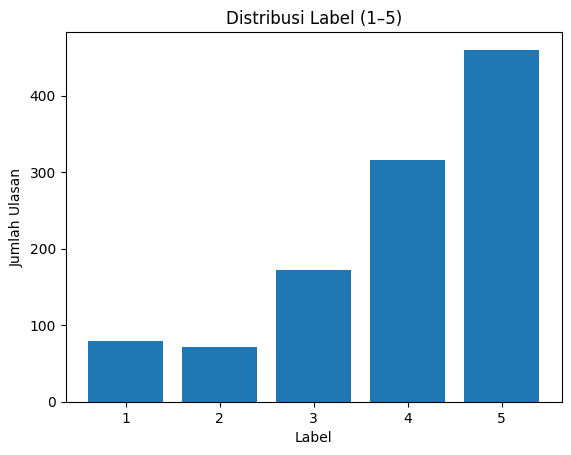

In [5]:
plt.figure()
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title(f"Distribusi Label ({'1–5'})")
plt.xlabel("Label")
plt.ylabel("Jumlah Ulasan")
plt.show()


In [6]:
df["char_len"] = df["text_basic"].str.len()
df["word_len"] = df["text_basic"].str.split().apply(len)

df[["char_len", "word_len"]].describe()


,char_len,word_len
count,1100.000000,1100.000000
mean,110.827273,20.051818
std,69.144698,12.977619
min,5.000000,1.000000
25%,62.000000,11.000000
50%,104.000000,19.000000
75%,147.000000,27.000000
max,914.000000,179.000000


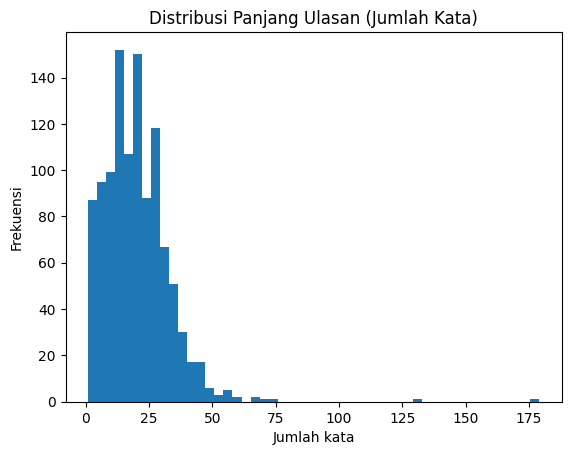

In [7]:
plt.figure()
plt.hist(df["word_len"], bins=50)
plt.title("Distribusi Panjang Ulasan (Jumlah Kata)")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()


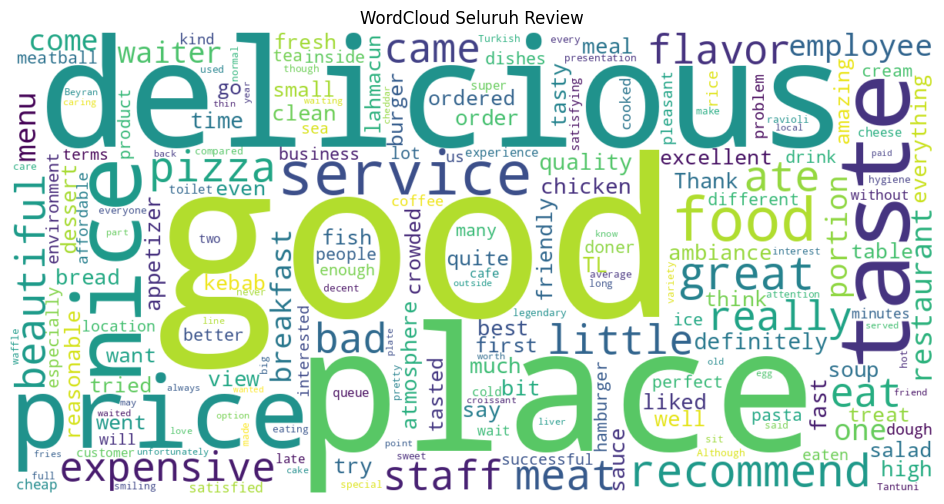

In [8]:
from wordcloud import WordCloud

all_text = " ".join(df["text_basic"].astype(str).tolist())

wc = WordCloud(width=1200, height=600, background_color="white", collocations=False).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Seluruh Review")
plt.show()


## 4. Train/Test Split


In [9]:
X = df["text_clean"].values
y = df["rating"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))
print("Distribusi Train:", Counter(y_train))
print("Distribusi Test :", Counter(y_test))


Train: 880 Test: 220
Distribusi Train: Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})
Distribusi Test : Counter({np.int64(5): 92, np.int64(4): 63, np.int64(3): 35, np.int64(1): 16, np.int64(2): 14})


## 5. Function Evaluasi


In [10]:
def eval_report(y_true, y_pred, title="Model", show_confusion=True):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    f1w = f1_score(y_true, y_pred, average="weighted")

    print(f"=== {title} ===")
    print("Accuracy :", round(acc, 4))
    print("F1-macro :", round(f1m, 4))
    print("F1-weight:", round(f1w, 4))
    print()
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    print()

    # ➜ Tambahan: plot confusion matrix
    if show_confusion:
        labels = sorted(list(set(y_true) | set(y_pred)))
        plot_confusion(
            y_true,
            y_pred,
            labels=labels,
            title=f"{title} – Confusion Matrix"
        )

    return {
        "model": title,
        "accuracy": acc,
        "f1_macro": f1m,
        "f1_weighted": f1w,
    }


def plot_confusion(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Plot confusion matrix dengan angka di setiap sel.
    """
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=list(labels))

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

    # Set ticks
    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels)

    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

    # ➜ Tempel angka di tiap sel
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            ax.text(
                j, i,
                str(value),
                ha="center", va="center",
                color="white" if value > thresh else "black",
                fontsize=9,
            )

    plt.tight_layout()
    plt.show()


## 6. Skenario 1 (Baseline TF‑IDF)


In [11]:
def fit_tfidf(train_texts, test_texts, max_features=50000, ngram_range=(1,2)):
    vec = TfidfVectorizer(
        lowercase=True,
        max_features=max_features,
        ngram_range=ngram_range
    )
    Xtr = vec.fit_transform(train_texts)
    Xte = vec.transform(test_texts)
    return vec, Xtr, Xte

In [12]:
results_s1 = []

### SVM


=== Linear SVM (S1 baseline) ===
Accuracy : 0.5
F1-macro : 0.3758
F1-weight: 0.4734

              precision    recall  f1-score   support

           1     0.5556    0.3125    0.4000        16
           2     0.3333    0.0714    0.1176        14
           3     0.3571    0.2857    0.3175        35
           4     0.3966    0.3651    0.3802        63
           5     0.5820    0.7717    0.6636        92

    accuracy                         0.5000       220
   macro avg     0.4449    0.3613    0.3758       220
weighted avg     0.4754    0.5000    0.4734       220




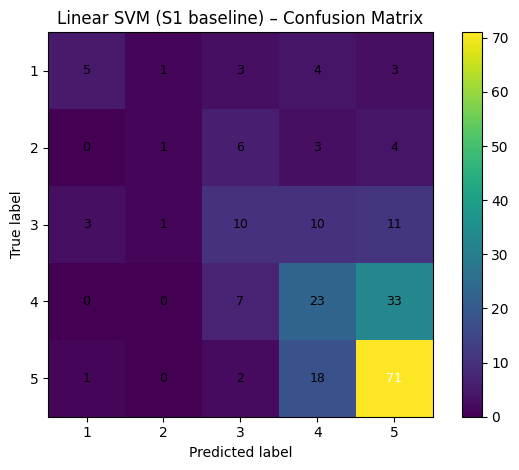

In [13]:
def train_eval_svm(train_texts, train_labels, test_texts, test_labels,
                   suffix="", class_weight=None, C=1.0,
                   max_features=50000, ngram_range=(1,2)):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts, max_features, ngram_range)
    svm = LinearSVC(class_weight=class_weight, C=C)
    svm.fit(Xtr, train_labels)
    pred = svm.predict(Xte)
    res = eval_report(test_labels, pred, f"Linear SVM{suffix}")
    return res, vec, svm, pred


svm_s1_res, _, _, _ = train_eval_svm(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)"
)
results_s1.append(svm_s1_res)


### NB


=== Naive Bayes (S1 baseline) ===
Accuracy : 0.4364
F1-macro : 0.1479
F1-weight: 0.2912

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        35
           4     0.5000    0.0794    0.1370        63
           5     0.4333    0.9891    0.6026        92

    accuracy                         0.4364       220
   macro avg     0.1867    0.2137    0.1479       220
weighted avg     0.3244    0.4364    0.2912       220




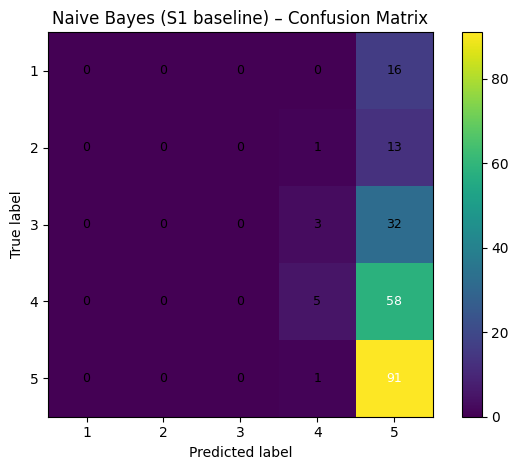

In [14]:
def train_eval_nb(train_texts, train_labels, test_texts, test_labels,
                  suffix="", max_features=50000, ngram_range=(1,2), alpha=1.0):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts, max_features, ngram_range)
    nb = MultinomialNB(alpha=alpha)
    nb.fit(Xtr, train_labels)
    pred = nb.predict(Xte)
    res = eval_report(test_labels, pred, f"Naive Bayes{suffix}")
    return res, vec, nb, pred


nb_s1_res, _, _, _ = train_eval_nb(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)"
)
results_s1.append(nb_s1_res)

### LR


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression (S1 baseline) ===
Accuracy : 0.4773
F1-macro : 0.2396
F1-weight: 0.4025

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.4545    0.1429    0.2174        35
           4     0.3393    0.3016    0.3193        63
           5     0.5294    0.8804    0.6612        92

    accuracy                         0.4773       220
   macro avg     0.2646    0.2650    0.2396       220
weighted avg     0.3909    0.4773    0.4025       220




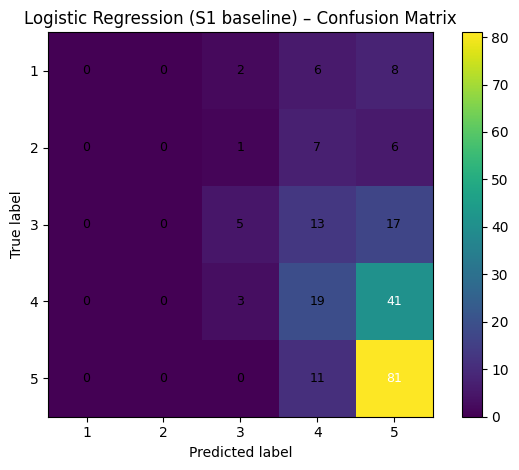

In [16]:
def train_eval_lr(train_texts, train_labels, test_texts, test_labels,
                  suffix="", class_weight=None, C=1.0,
                  max_features=50000, ngram_range=(1,2)):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts, max_features, ngram_range)

    lr = LogisticRegression(
        max_iter=2000,
        class_weight=class_weight,
        n_jobs=None,            # aman di Windows
        solver="saga",          # bagus utk sparse + multinomial
        multi_class="multinomial",
        C=C
    )
    lr.fit(Xtr, train_labels)
    pred = lr.predict(Xte)
    res = eval_report(test_labels, pred, f"Logistic Regression{suffix}")
    return res, vec, lr, pred


lr_s1_res, _, _, _ = train_eval_lr(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)"
)
results_s1.append(lr_s1_res)


### Recap


In [17]:
s1_table = pd.DataFrame(results_s1)

from IPython.display import display
    
s1_best = (
    s1_table
    .sort_values("f1_macro", ascending=False)
    .drop_duplicates(subset=["model"], keep="first")
    .reset_index(drop=True)
)

display(s1_best)


,model,accuracy,f1_macro,f1_weighted
0,Linear SVM (S1 baseline),0.500000,0.375765,0.473433
1,Logistic Regression (S1 baseline),0.477273,0.239589,0.402541
2,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245


## 7. Skenario 2 (Baseline Transformers (BERT & DistilBERT))


In [ ]:
# !pip install --upgrade datasets pyarrow pandas


In [ ]:
# !pip install -U "datasets>=3.1.0" "pyarrow>=16.0.0" pandas -q

In [18]:
!pip install -q evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [19]:
NUM_LABELS = 5
from datasets import Dataset
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

DEFAULT_MAX_LEN = 256 if HAS_GPU else 128
DEFAULT_BATCH = 8 if HAS_GPU else 2

# Max epoch besar + EarlyStopping biar fleksibel
DEFAULT_EPOCHS = 100 if HAS_GPU else 3

USE_SMALL_TRAIN_IF_CPU = True
SMALL_TRAIN_N = 2000

def make_hf_dataset(texts, labels):
    # label harus 0..num_labels-1
    return Dataset.from_dict({"text": list(texts), "label": [int(l) - 1 for l in labels]})

def make_tokenize_fn(tokenizer, max_length):
    def _tok(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_length)
    return _tok

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1m = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    f1w = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def maybe_shrink_train(train_texts, train_labels):
    if (not HAS_GPU) and USE_SMALL_TRAIN_IF_CPU and len(train_texts) > SMALL_TRAIN_N:
        return train_texts[:SMALL_TRAIN_N], train_labels[:SMALL_TRAIN_N]
    return train_texts, train_labels

def build_training_args(out_dir, epochs, batch_size):
    common = dict(
        output_dir=out_dir,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro", # bisa juga "eval_accuracy"
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none",
        seed=SEED,
        fp16=HAS_GPU,
        dataloader_num_workers=0,
    )
    try:
        return TrainingArguments(**common)
    except TypeError:
        # kompatibel utk versi transformers yang beda
        common.pop("evaluation_strategy", None)
        common["eval_strategy"] = "epoch"
        return TrainingArguments(**common)

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        inputs = dict(inputs)
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        base_model = model.module if hasattr(model, "module") else model
        num_labels = base_model.config.num_labels

        if self.class_weights is not None:
            cw = self.class_weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=cw)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def _build_trainer(model, args, train_tok, test_tok, tokenizer,
                   use_class_weights=False, class_weights=None):
    base_kwargs = dict(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    )

    cls = WeightedTrainer if use_class_weights else Trainer
    if use_class_weights:
        base_kwargs["class_weights"] = class_weights

    # tokenizer arg name changed in newer versions
    try:
        return cls(**base_kwargs, tokenizer=tokenizer)
    except TypeError:
        return cls(**base_kwargs, processing_class=tokenizer)

def safe_load_sequence_classifier(model_name, num_labels):
    # Coba beberapa cara loading untuk mengurangi potensi stuck/compat issue
    try:
        return AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, use_safetensors=True
        )
    except Exception:
        pass
    try:
        return AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, use_safetensors=False
        )
    except Exception:
        pass
    # fallback terakhir
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels
    )

def train_eval_transformer(
    model_name,
    train_texts, train_labels,
    test_texts, test_labels,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH,
    max_length=DEFAULT_MAX_LEN,
    out_dir="./tmp_tr",
    suffix="",
    use_class_weights=False
):
    train_texts2, train_labels2 = maybe_shrink_train(train_texts, train_labels)

    train_hf = make_hf_dataset(train_texts2, train_labels2)
    test_hf  = make_hf_dataset(test_texts, test_labels)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = safe_load_sequence_classifier(model_name, num_labels=5)

    tok_fn = make_tokenize_fn(tokenizer, max_length=max_length)
    train_tok = train_hf.map(tok_fn, batched=True)
    test_tok  = test_hf.map(tok_fn, batched=True)

    train_tok = train_tok.remove_columns(["text"]).rename_column("label", "labels")
    test_tok  = test_tok.remove_columns(["text"]).rename_column("label", "labels")

    args = build_training_args(out_dir, epochs, batch_size)

    class_weights = None
    if use_class_weights:
        classes = np.arange(1, 5 + 1)
        cw = compute_class_weight(
            class_weight="balanced",
            classes=classes,
            y=np.array(train_labels2)
        )
        class_weights = torch.tensor(cw, dtype=torch.float)

    trainer = _build_trainer(
        model=model,
        args=args,
        train_tok=train_tok,
        test_tok=test_tok,
        tokenizer=tokenizer,
        use_class_weights=use_class_weights,
        class_weights=class_weights
    )

    trainer.train()
    res = trainer.evaluate()

    pred_output = trainer.predict(test_tok)
    logits = pred_output.predictions
    preds_0_based = np.argmax(logits, axis=-1)        # 0..4
    preds_1_based = preds_0_based + 1                 

    y_true = np.array(test_labels)                    # 1..5
    y_pred = preds_1_based

    print(f"\nConfusion Matrix for {model_name}{suffix}")
    plot_confusion(
        y_true,
        y_pred,
        labels=[1, 2, 3, 4, 5],
        title=f"{model_name}{suffix} – Confusion Matrix"
    )

    out = {
        "model": model_name + suffix,
        "accuracy": res.get("eval_accuracy"),
        "f1_macro": res.get("eval_f1_macro"),
        "f1_weighted": res.get("eval_f1_weighted"),
        "eval_loss": res.get("eval_loss"),
        "epoch": res.get("epoch"),
    }

    print(f"=== {model_name}{suffix} ===")
    print(res)
    print()
    return out


2025-12-18 21:28:58.126685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766093338.373517      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766093338.443999      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766093339.053148      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766093339.053193      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766093339.053196      55 computation_placer.cc:177] computation placer alr

In [20]:
results_s2 = []

### BERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_55/2167427641.py:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return cls(**base_kwargs, tokenizer=tokenizer)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.451300,1.307374,0.413636,0.122565,0.252279
2,1.188400,1.090827,0.559091,0.317640,0.501875
3,0.919100,1.089650,0.531818,0.318317,0.499169
4,0.744200,1.197218,0.518182,0.351645,0.502506
5,0.595100,1.377648,0.536364,0.420316,0.533823
6,0.403000,1.523710,0.531818,0.368360,0.516706


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Confusion Matrix for bert-base-uncased (S2 baseline)


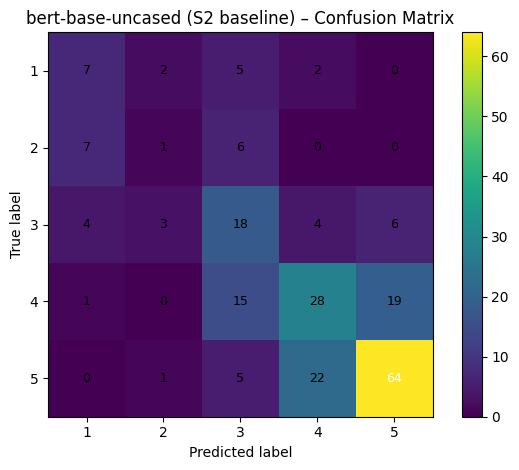

=== bert-base-uncased (S2 baseline) ===
{'eval_loss': 1.3776477575302124, 'eval_accuracy': 0.5363636363636364, 'eval_f1_macro': 0.42031601590912604, 'eval_f1_weighted': 0.5338234801705715, 'eval_runtime': 2.3595, 'eval_samples_per_second': 93.241, 'eval_steps_per_second': 5.934, 'epoch': 6.0}



In [21]:
try:
    bert_s2_res = train_eval_transformer(
        "bert-base-uncased",
        X_train, y_train, X_test, y_test,
        out_dir="./tmp_bert_s2",
        suffix=" (S2 baseline)",
        use_class_weights=False
    )
    results_s2.append(bert_s2_res)
except Exception as e:
    print("BERT S2 error:", e)


### DistilBERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_55/2167427641.py:113: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return cls(**base_kwargs, tokenizer=tokenizer)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.399500,1.195489,0.495455,0.213232,0.404317
2,1.154200,1.063532,0.563636,0.319915,0.506079
3,0.952400,1.036261,0.563636,0.376724,0.535289
4,0.812700,1.085292,0.568182,0.344098,0.534172


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Confusion Matrix for distilbert-base-uncased (S2 baseline)


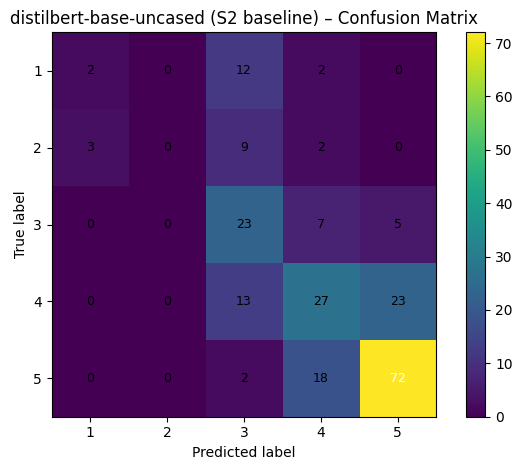

=== distilbert-base-uncased (S2 baseline) ===
{'eval_loss': 1.0362614393234253, 'eval_accuracy': 0.5636363636363636, 'eval_f1_macro': 0.3767238810417784, 'eval_f1_weighted': 0.5352886996191126, 'eval_runtime': 1.1382, 'eval_samples_per_second': 193.281, 'eval_steps_per_second': 12.3, 'epoch': 4.0}



In [22]:
try:
    distil_s2_res = train_eval_transformer(
        "distilbert-base-uncased",
        X_train, y_train, X_test, y_test,
        out_dir="./tmp_distil_s2",
        suffix=" (S2 baseline)",
        use_class_weights=False
    )
    results_s2.append(distil_s2_res)
except Exception as e:
    print("DistilBERT S2 error:", e)


### Recap


In [24]:
s2_table = pd.DataFrame(results_s2)
s2_best = (
    s2_table
    .sort_values("f1_macro", ascending=False)
    .drop_duplicates(subset=["model"], keep="first")
    .reset_index(drop=True)
)

display(s2_best)


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
0,bert-base-uncased (S2 baseline),0.536364,0.420316,0.533823,1.377648,6.0
1,distilbert-base-uncased (S2 baseline),0.563636,0.376724,0.535289,1.036261,4.0


## 8. Skenario 3 — Augmentasi


In [31]:
def get_synonyms(word):
    syns = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            w = lemma.name().replace("_", " ").lower()
            if w != word.lower():
                syns.add(w)
    return list(syns)

def random_deletion(words, p=0.1):
    if len(words) <= 1:
        return words
    new_words = [w for w in words if random.random() > p]
    return new_words if new_words else [random.choice(words)]

def random_swap(words, n=1):
    new_words = words[:]
    for _ in range(n):
        if len(new_words) < 2:
            break
        i, j = random.sample(range(len(new_words)), 2)
        new_words[i], new_words[j] = new_words[j], new_words[i]
    return new_words

def random_insertion(words, n=1):
    new_words = words[:]
    for _ in range(n):
        if not new_words:
            break
        w = random.choice(new_words)
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words.insert(random.randint(0, len(new_words)), random.choice(syns))
    return new_words

def synonym_replacement(words, n=1):
    new_words = words[:]
    candidates = [w for w in set(words) if get_synonyms(w)]
    random.shuffle(candidates)
    num_replaced = 0
    for w in candidates:
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words = [random.choice(syns) if x == w else x for x in new_words]
        num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

In [32]:
def eda(text, alpha=0.1, num_aug=1):
    words = str(text).split()
    if not words:
        return [str(text)] * num_aug
    n = max(1, int(alpha * len(words)))
    augmented = []
    for _ in range(num_aug):
        choice = random.choice(["sr", "ri", "rs", "rd"])
        if choice == "sr":
            w = synonym_replacement(words, n)
        elif choice == "ri":
            w = random_insertion(words, n)
        elif choice == "rs":
            w = random_swap(words, n)
        else:
            w = random_deletion(words, p=alpha)
        augmented.append(" ".join(w))
    return augmented

def modified_eda(text, alpha=0.05, num_aug=1):
    return eda(text, alpha=alpha, num_aug=num_aug)


In [33]:
_BERT_AUG = None

def get_bert_aug():
    global _BERT_AUG
    if _BERT_AUG is not None:
        return _BERT_AUG

    import nlpaug.augmenter.word as naw
    device = "cuda" if torch.cuda.is_available() else "cpu"

    try:
        _BERT_AUG = naw.ContextualWordEmbsAug(
            model_path="bert-base-uncased",
            action="substitute",
            device=device
        )
    except TypeError:
        # fallback untuk versi nlpaug lama
        _BERT_AUG = naw.ContextualWordEmbsAug(
            model_path="bert-base-uncased",
            action="substitute"
        )
    return _BERT_AUG

def bert_augment(text, num_aug=1):
    try:
        aug = get_bert_aug()
        out = aug.augment(text, n=num_aug)
        if isinstance(out, str):
            out = [out]
        return out
    except Exception:
        return [text] * num_aug


In [36]:
_BT_CACHE = {}

def get_bt_models(src_lang="en", mid_lang="fr"):
    key = (src_lang, mid_lang)
    if key in _BT_CACHE:
        return _BT_CACHE[key]

    from transformers import MarianMTModel, MarianTokenizer

    model_name_1 = f"Helsinki-NLP/opus-mt-{src_lang}-{mid_lang}"
    model_name_2 = f"Helsinki-NLP/opus-mt-{mid_lang}-{src_lang}"

    tok1 = MarianTokenizer.from_pretrained(model_name_1)
    mod1 = MarianMTModel.from_pretrained(model_name_1)
    tok2 = MarianTokenizer.from_pretrained(model_name_2)
    mod2 = MarianMTModel.from_pretrained(model_name_2)

    if torch.cuda.is_available():
        mod1 = mod1.to("cuda")
        mod2 = mod2.to("cuda")

    _BT_CACHE[key] = (tok1, mod1, tok2, mod2)
    return _BT_CACHE[key]

def _translate_one(text, tok, mod, max_length=256):
    dev = next(mod.parameters()).device
    batch = tok([text], return_tensors="pt", truncation=True, padding=True)
    batch = {k: v.to(dev) for k, v in batch.items()}
    gen = mod.generate(**batch, max_length=max_length)
    return tok.batch_decode(gen, skip_special_tokens=True)[0]

def backtranslate(text, src_lang="en", mid_lang="fr"):
    try:
        tok1, mod1, tok2, mod2 = get_bt_models(src_lang, mid_lang)
        mid = _translate_one(text, tok1, mod1)
        back = _translate_one(mid, tok2, mod2)
        return back
    except Exception:
        return text


In [37]:
def augment_minority(
    texts, labels,
    strategy="eda",
    target_multiplier=1.0,
    max_aug_per_sample=1
):
    texts = list(texts)
    labels = list(labels)

    counts = Counter(labels)
    max_count = max(counts.values())
    target_count = int(max_count * target_multiplier)

    new_texts = texts[:]
    new_labels = labels[:]

    idx_by_class = {c: [] for c in counts}
    for i, lab in enumerate(labels):
        idx_by_class[lab].append(i)

    for c, idxs in idx_by_class.items():
        need = max(0, target_count - counts[c])
        if need == 0:
            continue

        pool = idxs[:]
        random.shuffle(pool)
        ptr = 0

        while need > 0 and pool:
            i = pool[ptr % len(pool)]
            base = texts[i]
            k = min(max_aug_per_sample, need)

            if strategy == "eda":
                aug_texts = eda(base, alpha=0.1, num_aug=k)
            elif strategy == "modified_eda":
                aug_texts = modified_eda(base, alpha=0.05, num_aug=k)
            elif strategy == "bert":
                aug_texts = bert_augment(base, num_aug=k)
            elif strategy == "backtranslation":
                aug_texts = [backtranslate(base) for _ in range(k)]
            else:
                aug_texts = []

            for t in aug_texts:
                if need <= 0:
                    break
                new_texts.append(t)
                new_labels.append(c)
                need -= 1

            ptr += 1

    return np.array(new_texts), np.array(new_labels)


In [40]:
def post_clean_texts(texts):
    return [lemmatize_text(t) for t in texts]

In [41]:
# Cara aman: split ulang index-based
idx = np.arange(len(df))
train_idx, test_idx = train_test_split(
    idx,
    test_size=0.2,
    random_state=SEED,
    stratify=df["rating"].values
)

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

X_train_basic = df_train["text_basic"].values
y_train_s3    = df_train["rating"].values

X_test_basic  = df_test["text_basic"].values
y_test_s3_orig = df_test["rating"].values

print("S3 Train size (before aug):", len(X_train_basic))
print("S3 Test size (before aug):", len(X_test_basic))
print("Distribusi S3 train (original):", Counter(y_train_s3))
print("Distribusi S3 test (original):", Counter(y_test_s3_orig))

# Balance test set using EDA augmentation (lighter method for test)
print("\nBalancing test set...")
X_test_basic_balanced, y_test_s3_balanced = augment_minority(
    X_test_basic, y_test_s3_orig,
    strategy="eda",
    target_multiplier=0.8,  # Balance to 80% of max class
    max_aug_per_sample=1
)

# Clean the balanced test set
X_test_clean = post_clean_texts(X_test_basic_balanced)
y_test_s3 = y_test_s3_balanced

print("S3 Test size (after balancing):", len(X_test_clean))
print("Distribusi S3 test (balanced):", Counter(y_test_s3))


S3 Train size (before aug): 880
S3 Test size (before aug): 220
Distribusi S3 train (original): Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})
Distribusi S3 test (original): Counter({np.int64(5): 92, np.int64(4): 63, np.int64(3): 35, np.int64(1): 16, np.int64(2): 14})

Balancing test set...
S3 Test size (after balancing): 384
Distribusi S3 test (balanced): Counter({np.int64(5): 92, np.int64(1): 73, np.int64(3): 73, np.int64(4): 73, np.int64(2): 73})


Save Output


In [43]:
!pip install sacremoses

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 15.0 MB/s eta 0:00:00a 0:00:01


In [44]:
AUG_OUT_DIR = "./aug_outputs"
os.makedirs(AUG_OUT_DIR, exist_ok=True)

AUG_STRATEGIES = ["eda", "modified_eda", "bert", "backtranslation"]

TARGET_MULTIPLIER = 1.0
MAX_AUG_PER_SAMPLE = 1   

print("Distribusi train original:", Counter(y_train_s3))
print("AUG_STRATEGIES:", AUG_STRATEGIES)



def build_aug_dataframe(strategy):
    Xa, ya = augment_minority(
        X_train_basic, y_train_s3,
        strategy=strategy,
        target_multiplier=TARGET_MULTIPLIER,
        max_aug_per_sample=MAX_AUG_PER_SAMPLE
    )

    Xa_clean = post_clean_texts(Xa)

    df_aug = pd.DataFrame({
        "text_basic_aug": Xa,
        "text_clean_aug": Xa_clean,
        "label": ya
    })
    return df_aug

def save_aug_csv(strategy):
    df_aug = build_aug_dataframe(strategy)
    out_path = os.path.join(AUG_OUT_DIR, f"train_aug_{strategy}.csv")
    df_aug.to_csv(out_path, index=False)
    print(f"Saved: {out_path} | shape={df_aug.shape} | dist={Counter(df_aug['label'])}")
    return out_path

AUG_PATHS = {}
for strat in AUG_STRATEGIES:
    try:
        AUG_PATHS[strat] = save_aug_csv(strat)
    except Exception as e:
        print("Aug error:", strat, e)

AUG_PATHS


Distribusi train original: Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})
AUG_STRATEGIES: ['eda', 'modified_eda', 'bert', 'backtranslation']
Saved: ./aug_outputs/train_aug_eda.csv | shape=(1840, 3) | dist=Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})
Saved: ./aug_outputs/train_aug_modified_eda.csv | shape=(1840, 3) | dist=Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})
Saved: ./aug_outputs/train_aug_bert.csv | shape=(1840, 3) | dist=Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})
Saved: ./aug_outputs/train_aug_backtranslation.csv | shape=(1840, 3) | dist=Counter({4: 368, 5: 368, 2: 368, 3: 368, 1: 368})


{'eda': './aug_outputs/train_aug_eda.csv',
 'modified_eda': './aug_outputs/train_aug_modified_eda.csv',
 'bert': './aug_outputs/train_aug_bert.csv',
 'backtranslation': './aug_outputs/train_aug_backtranslation.csv'}

### Contoh Sample


In [45]:
def show_aug_examples(sample_text=None):
    if sample_text is None:
        sample_text = random.choice(list(X_train_basic))

    rows = []
    rows.append(("original (basic)", sample_text))
    rows.append(("original (clean)", lemmatize_text(sample_text)))

    # Show one example each operation family using EDA/Modified EDA
    rows.append(("EDA sr/ri/rs/rd (1 sample)", eda(sample_text, alpha=0.1, num_aug=1)[0]))
    rows.append(("Modified EDA (1 sample)", modified_eda(sample_text, alpha=0.05, num_aug=1)[0]))

    # BERT aug
    rows.append(("BERT aug (1 sample)", bert_augment(sample_text, num_aug=1)[0]))

    # Backtranslation
    rows.append(("Backtranslation (1 sample)", backtranslate(sample_text)))

    ex = pd.DataFrame(rows, columns=["method", "sentence"])
    return ex

example_df = show_aug_examples()

print("\n=== FULL SENTENCES ===")
for method, sentence in example_df.itertuples(index=False):
    print(f"[{method}]")
    print(sentence)
    print("-" * 80)



=== FULL SENTENCES ===
[original (basic)]
When I went; I waited for almost 20 minutes for the waiters to take care of me. The taste was not bad. The surrounding was beautiful.
--------------------------------------------------------------------------------
[original (clean)]
when i go i wait for almost minute for the waiter to take care of me the taste be not bad the surrounding be beautiful
--------------------------------------------------------------------------------
[EDA sr/ri/rs/rd (1 sample)]
When I went; I waited for almost 20 minutes for the waiters to take not of me. The taste was was bad. The surrounding care beautiful.
--------------------------------------------------------------------------------
[Modified EDA (1 sample)]
When I I went; waited for almost 20 minutes for the waiters to take care of me. The taste was not bad. The surrounding was beautiful.
--------------------------------------------------------------------------------
[BERT aug (1 sample)]
When I went; I w

In [49]:
# def load_aug(strategy):
#     path = os.path.join(AUG_OUT_DIR, f"train_aug_{strategy}.csv")
#     if not os.path.exists(path):
#         raise FileNotFoundError(path)
#     df_aug = pd.read_csv(path)
#     Xtr = df_aug["text_clean_aug"].astype(str).values
#     ytr = df_aug["label"].astype(int).values
#     return Xtr, ytr, df_aug

# # Test set is already balanced from previous cell
# print("Test dist (S3 - balanced):", Counter(y_test_s3))
# print("Test size:", len(X_test_clean))


def load_aug(strategy):
    path = os.path.join(AUG_OUT_DIR, f"train_aug_{strategy}.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    df_aug = pd.read_csv(path)
    Xtr = df_aug["text_clean_aug"].astype(str).values
    ytr = df_aug["label"].astype(int).values
    return Xtr, ytr, df_aug

# test set clean labels
X_test_s3 = X_test_clean
y_test_s3 = y_test_s3

# Test set is already balanced from previous cell
print("Test dist (S3 - balanced):", Counter(y_test_s3))
print("Test size:", len(X_test_clean))

Test dist (S3 - balanced): Counter({np.int64(5): 92, np.int64(1): 73, np.int64(3): 73, np.int64(4): 73, np.int64(2): 73})
Test size: 384


In [47]:
results_s3 = []

### TFIDF



------------------------------------------------------------
S3 | TF-IDF models | Strategy: eda
Train dist: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 aug=eda) ===
Accuracy : 0.3984
F1-macro : 0.3756
F1-weight: 0.3858

              precision    recall  f1-score   support

           1     0.5897    0.3151    0.4107        73
           2     0.3171    0.1781    0.2281        73
           3     0.3117    0.3288    0.3200        73
           4     0.2929    0.3973    0.3372        73
           5     0.5000    0.6957    0.5818        92

    accuracy                         0.3984       384
   macro avg     0.4023    0.3830    0.3756       384
weighted avg     0.4071    0.3984    0.3858       384




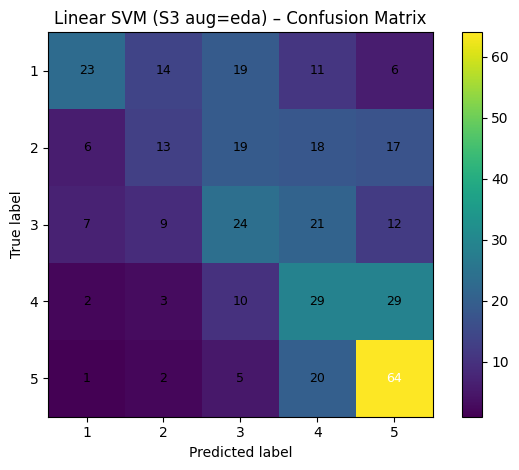

=== Naive Bayes (S3 aug=eda) ===
Accuracy : 0.4375
F1-macro : 0.4291
F1-weight: 0.4385

              precision    recall  f1-score   support

           1     0.6304    0.3973    0.4874        73
           2     0.3371    0.4110    0.3704        73
           3     0.3472    0.3425    0.3448        73
           4     0.3200    0.3288    0.3243        73
           5     0.5882    0.6522    0.6186        92

    accuracy                         0.4375       384
   macro avg     0.4446    0.4263    0.4291       384
weighted avg     0.4517    0.4375    0.4385       384




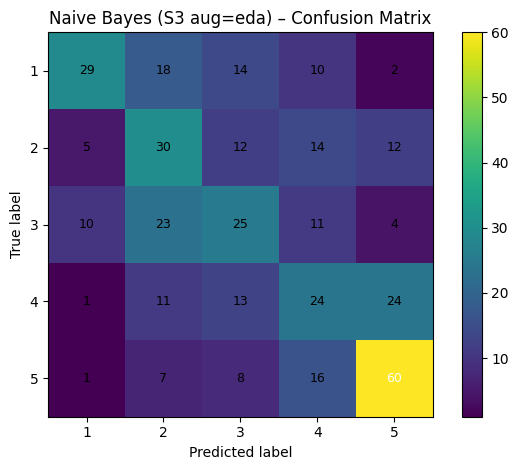

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression (S3 aug=eda) ===
Accuracy : 0.4245
F1-macro : 0.4077
F1-weight: 0.418

              precision    recall  f1-score   support

           1     0.6190    0.3562    0.4522        73
           2     0.3333    0.2466    0.2835        73
           3     0.3418    0.3699    0.3553        73
           4     0.3000    0.3699    0.3313        73
           5     0.5462    0.7065    0.6161        92

    accuracy                         0.4245       384
   macro avg     0.4281    0.4098    0.4077       384
weighted avg     0.4339    0.4245    0.4180       384




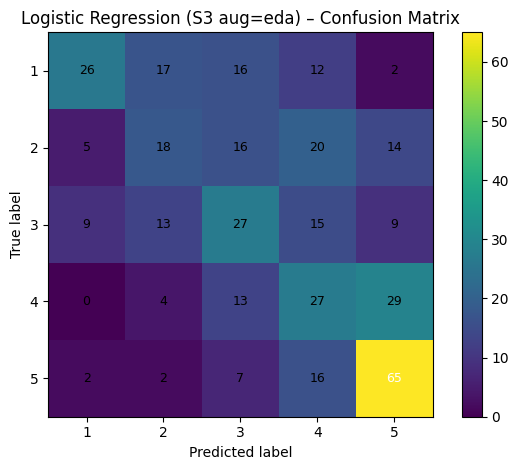


------------------------------------------------------------
S3 | TF-IDF models | Strategy: modified_eda
Train dist: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 aug=modified_eda) ===
Accuracy : 0.3854
F1-macro : 0.3588
F1-weight: 0.3702

              precision    recall  f1-score   support

           1     0.6216    0.3151    0.4182        73
           2     0.3030    0.1370    0.1887        73
           3     0.2875    0.3151    0.3007        73
           4     0.2549    0.3562    0.2971        73
           5     0.5000    0.7174    0.5893        92

    accuracy                         0.3854       384
   macro avg     0.3934    0.3681    0.3588       384
weighted avg     0.3987    0.3854    0.3702       384




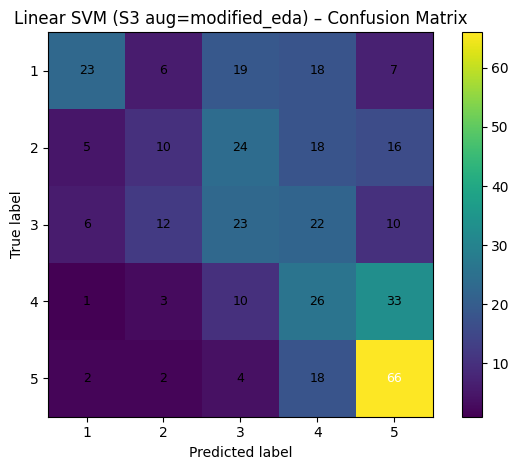

=== Naive Bayes (S3 aug=modified_eda) ===
Accuracy : 0.4505
F1-macro : 0.4464
F1-weight: 0.4537

              precision    recall  f1-score   support

           1     0.6538    0.4658    0.5440        73
           2     0.3505    0.4658    0.4000        73
           3     0.3600    0.3699    0.3649        73
           4     0.3433    0.3151    0.3286        73
           5     0.5914    0.5978    0.5946        92

    accuracy                         0.4505       384
   macro avg     0.4598    0.4429    0.4464       384
weighted avg     0.4663    0.4505    0.4537       384




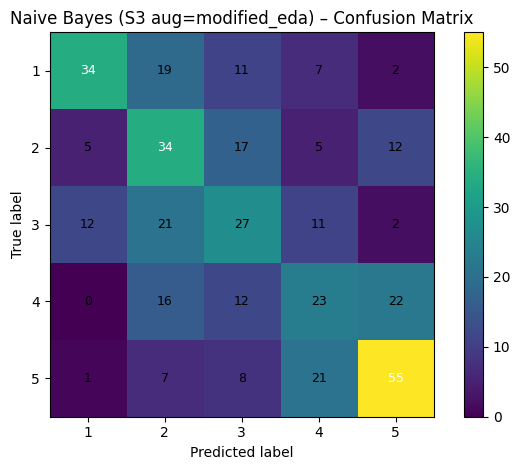

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression (S3 aug=modified_eda) ===
Accuracy : 0.4089
F1-macro : 0.3881
F1-weight: 0.3993

              precision    recall  f1-score   support

           1     0.6098    0.3425    0.4386        73
           2     0.3125    0.2055    0.2479        73
           3     0.2911    0.3151    0.3026        73
           4     0.3011    0.3836    0.3373        73
           5     0.5366    0.7174    0.6140        92

    accuracy                         0.4089       384
   macro avg     0.4102    0.3928    0.3881       384
weighted avg     0.4165    0.4089    0.3993       384




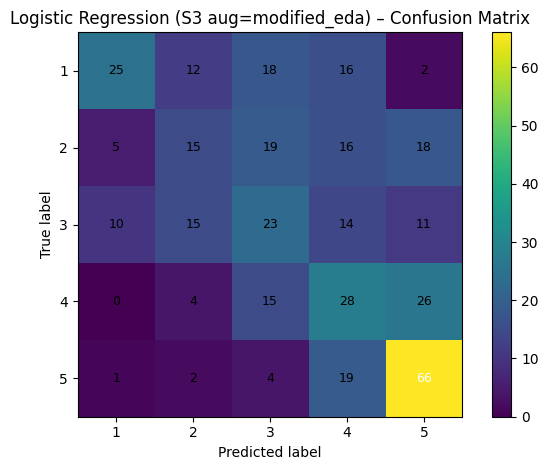


------------------------------------------------------------
S3 | TF-IDF models | Strategy: bert
Train dist: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 aug=bert) ===
Accuracy : 0.3802
F1-macro : 0.3505
F1-weight: 0.3605

              precision    recall  f1-score   support

           1     0.6176    0.2877    0.3925        73
           2     0.3333    0.1233    0.1800        73
           3     0.3117    0.3288    0.3200        73
           4     0.2621    0.3699    0.3068        73
           5     0.4545    0.7065    0.5532        92

    accuracy                         0.3802       384
   macro avg     0.3959    0.3632    0.3505       384
weighted avg     0.3988    0.3802    0.3605       384




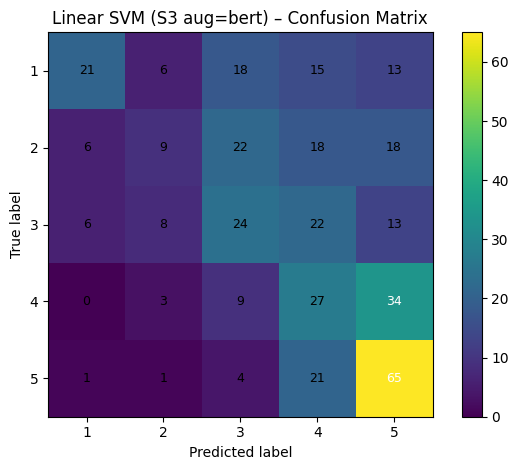

=== Naive Bayes (S3 aug=bert) ===
Accuracy : 0.4453
F1-macro : 0.4424
F1-weight: 0.4499

              precision    recall  f1-score   support

           1     0.6275    0.4384    0.5161        73
           2     0.3299    0.4384    0.3765        73
           3     0.3457    0.3836    0.3636        73
           4     0.3846    0.3425    0.3623        73
           5     0.6000    0.5870    0.5934        92

    accuracy                         0.4453       384
   macro avg     0.4575    0.4379    0.4424       384
weighted avg     0.4646    0.4453    0.4499       384




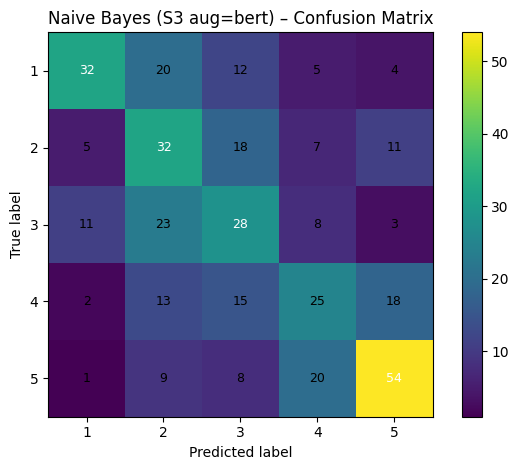

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression (S3 aug=bert) ===
Accuracy : 0.3932
F1-macro : 0.3714
F1-weight: 0.3817

              precision    recall  f1-score   support

           1     0.5882    0.2740    0.3738        73
           2     0.3182    0.1918    0.2393        73
           3     0.3077    0.3288    0.3179        73
           4     0.2925    0.4247    0.3464        73
           5     0.5082    0.6739    0.5794        92

    accuracy                         0.3932       384
   macro avg     0.4030    0.3786    0.3714       384
weighted avg     0.4082    0.3932    0.3817       384




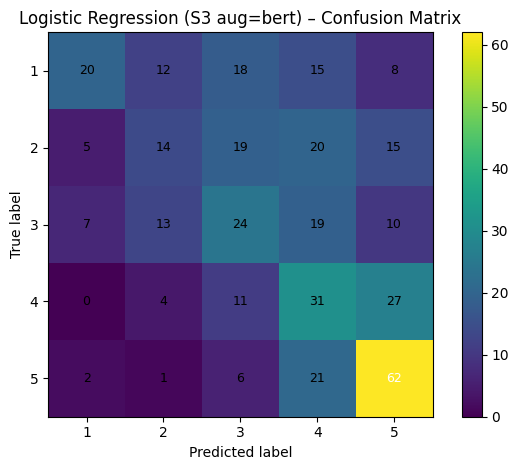


------------------------------------------------------------
S3 | TF-IDF models | Strategy: backtranslation
Train dist: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 aug=backtranslation) ===
Accuracy : 0.3828
F1-macro : 0.3583
F1-weight: 0.3673

              precision    recall  f1-score   support

           1     0.6316    0.3288    0.4324        73
           2     0.3200    0.1096    0.1633        73
           3     0.3038    0.3288    0.3158        73
           4     0.2759    0.4384    0.3386        73
           5     0.4683    0.6413    0.5413        92

    accuracy                         0.3828       384
   macro avg     0.3999    0.3694    0.3583       384
weighted avg     0.4033    0.3828    0.3673       384




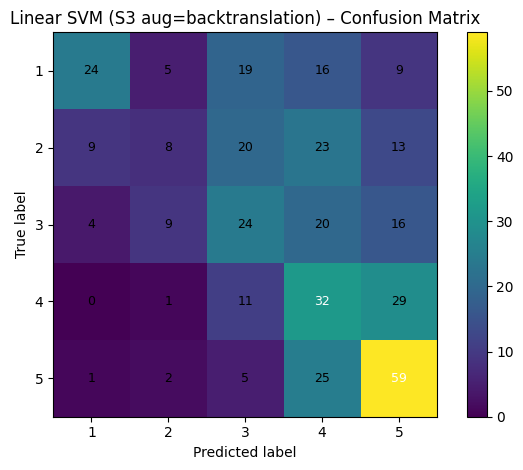

=== Naive Bayes (S3 aug=backtranslation) ===
Accuracy : 0.3958
F1-macro : 0.3933
F1-weight: 0.4034

              precision    recall  f1-score   support

           1     0.5902    0.4932    0.5373        73
           2     0.2353    0.2740    0.2532        73
           3     0.2159    0.2603    0.2360        73
           4     0.3770    0.3151    0.3433        73
           5     0.6067    0.5870    0.5967        92

    accuracy                         0.3958       384
   macro avg     0.4050    0.3859    0.3933       384
weighted avg     0.4150    0.3958    0.4034       384




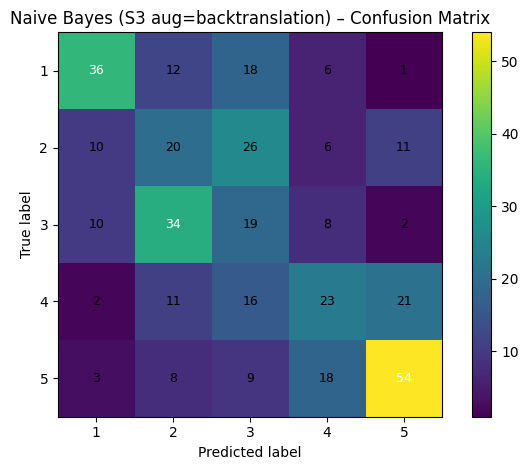

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression (S3 aug=backtranslation) ===
Accuracy : 0.3958
F1-macro : 0.3715
F1-weight: 0.3814

              precision    recall  f1-score   support

           1     0.5714    0.3288    0.4174        73
           2     0.2703    0.1370    0.1818        73
           3     0.3103    0.3699    0.3375        73
           4     0.3118    0.3973    0.3494        73
           5     0.4960    0.6739    0.5714        92

    accuracy                         0.3958       384
   macro avg     0.3920    0.3814    0.3715       384
weighted avg     0.3971    0.3958    0.3814       384




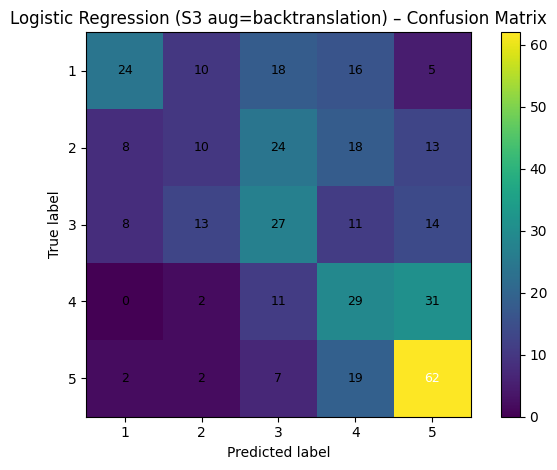

,model,accuracy,f1_macro,f1_weighted
0,Linear SVM (S3 aug=eda),0.398438,0.375562,0.385768
1,Naive Bayes (S3 aug=eda),0.437500,0.429095,0.438469
2,Logistic Regression (S3 aug=eda),0.424479,0.407661,0.417975
3,Linear SVM (S3 aug=modified_eda),0.385417,0.358789,0.370193
4,Naive Bayes (S3 aug=modified_eda),0.450521,0.446406,0.453738
5,Logistic Regression (S3 aug=modified_eda),0.408854,0.388093,0.399268
6,Linear SVM (S3 aug=bert),0.380208,0.350507,0.360535
7,Naive Bayes (S3 aug=bert),0.445312,0.442392,0.449864
8,Logistic Regression (S3 aug=bert),0.393229,0.371367,0.381663
9,Linear SVM (S3 aug=backtranslation),0.382812,0.358279,0.367334


In [50]:
for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | TF-IDF models | Strategy:", strat)

    try:
        Xtr_aug, ytr_aug, _ = load_aug(strat)
        print("Train dist:", Counter(ytr_aug))

        # SVM
        svm_res, _, _, _ = train_eval_svm(
            Xtr_aug, ytr_aug, X_test_s3, y_test_s3,
            suffix=f" (S3 aug={strat})"
        )
        results_s3.append(svm_res)

        # NB
        nb_res, _, _, _ = train_eval_nb(
            Xtr_aug, ytr_aug, X_test_s3, y_test_s3,
            suffix=f" (S3 aug={strat})"
        )
        results_s3.append(nb_res)

        # LR
        lr_res, _, _, _ = train_eval_lr(
            Xtr_aug, ytr_aug, X_test_s3, y_test_s3,
            suffix=f" (S3 aug={strat})"
        )
        results_s3.append(lr_res)

    except Exception as e:
        print("S3 TF-IDF error:", strat, e)

s3_tfidf_table = pd.DataFrame(results_s3)
s3_tfidf_table


### Transformer



------------------------------------------------------------
S3 | Transformers | Strategy: eda
Train dist: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

/tmp/ipykernel_55/2167427641.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.221000,1.317031,0.390625,0.384021,0.389032
2,0.795600,1.515278,0.416667,0.366230,0.382984


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Confusion Matrix for bert-base-uncased (S3 aug=eda)


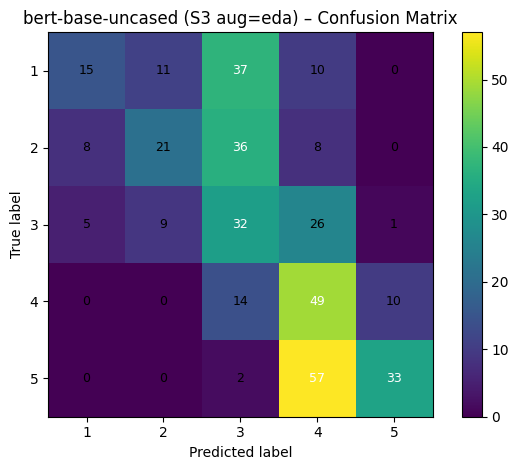

=== bert-base-uncased (S3 aug=eda) ===
{'eval_loss': 1.3170305490493774, 'eval_accuracy': 0.390625, 'eval_f1_macro': 0.3840207327747003, 'eval_f1_weighted': 0.3890316554636972, 'eval_runtime': 4.0927, 'eval_samples_per_second': 93.825, 'eval_steps_per_second': 5.864, 'epoch': 2.0}



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

/tmp/ipykernel_55/2167427641.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.274600,1.289612,0.427083,0.403683,0.415804
2,0.804200,1.470047,0.401042,0.388748,0.400049


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Confusion Matrix for distilbert-base-uncased (S3 aug=eda)


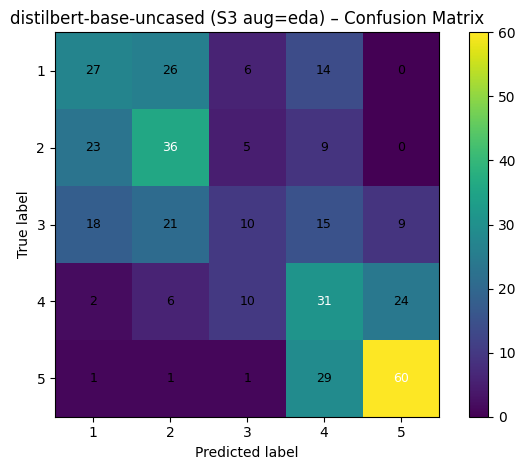

=== distilbert-base-uncased (S3 aug=eda) ===
{'eval_loss': 1.2896124124526978, 'eval_accuracy': 0.4270833333333333, 'eval_f1_macro': 0.4036831459902174, 'eval_f1_weighted': 0.4158038349238377, 'eval_runtime': 2.0066, 'eval_samples_per_second': 191.373, 'eval_steps_per_second': 11.961, 'epoch': 2.0}


------------------------------------------------------------
S3 | Transformers | Strategy: modified_eda
Train dist: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

/tmp/ipykernel_55/2167427641.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.178200,1.407637,0.348958,0.332923,0.334592
2,0.620200,1.827677,0.393229,0.356966,0.372940
3,0.354500,2.023665,0.395833,0.373419,0.387750
4,0.183500,2.393210,0.390625,0.367077,0.381901


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Confusion Matrix for bert-base-uncased (S3 aug=modified_eda)


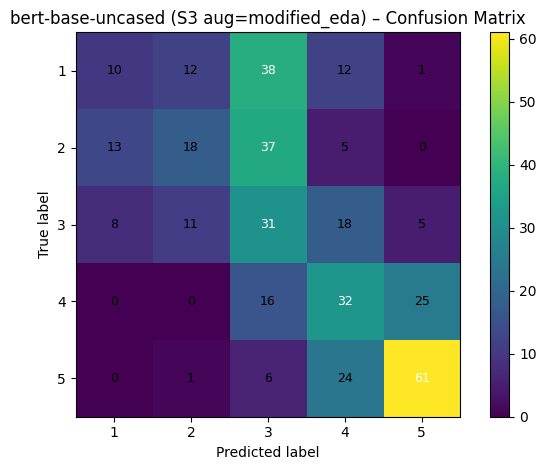

=== bert-base-uncased (S3 aug=modified_eda) ===
{'eval_loss': 2.023664712905884, 'eval_accuracy': 0.3958333333333333, 'eval_f1_macro': 0.37341925254224845, 'eval_f1_weighted': 0.3877496178772843, 'eval_runtime': 4.704, 'eval_samples_per_second': 81.632, 'eval_steps_per_second': 5.102, 'epoch': 4.0}



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

/tmp/ipykernel_55/2167427641.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.254400,1.318646,0.393229,0.371276,0.374647
2,0.779500,1.546786,0.416667,0.382899,0.397107
3,0.479200,1.793063,0.424479,0.393809,0.408309
4,0.293600,2.074457,0.419271,0.394985,0.408093
5,0.177200,2.592377,0.411458,0.371411,0.386849


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Confusion Matrix for distilbert-base-uncased (S3 aug=modified_eda)


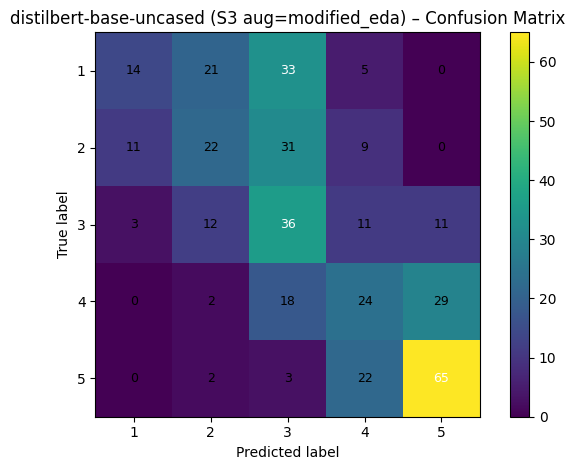

=== distilbert-base-uncased (S3 aug=modified_eda) ===
{'eval_loss': 2.0744566917419434, 'eval_accuracy': 0.4192708333333333, 'eval_f1_macro': 0.3949853774429722, 'eval_f1_weighted': 0.40809305685592373, 'eval_runtime': 2.0359, 'eval_samples_per_second': 188.618, 'eval_steps_per_second': 11.789, 'epoch': 5.0}


------------------------------------------------------------
S3 | Transformers | Strategy: bert
Train dist: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

/tmp/ipykernel_55/2167427641.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.303700,1.392962,0.367188,0.334016,0.348341
2,0.782600,1.656159,0.406250,0.354941,0.371294
3,0.388100,1.988621,0.414062,0.373809,0.387767
4,0.204900,2.474778,0.388021,0.339254,0.354373


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Confusion Matrix for bert-base-uncased (S3 aug=bert)


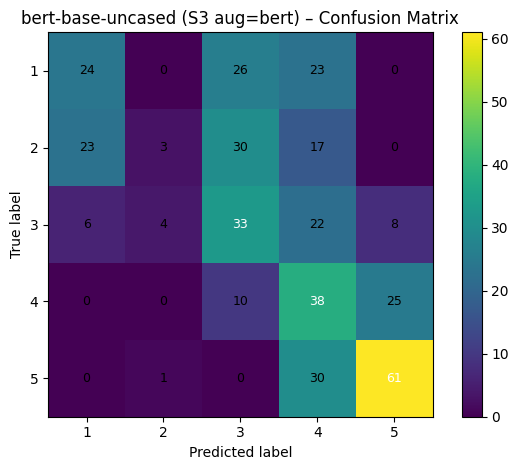

=== bert-base-uncased (S3 aug=bert) ===
{'eval_loss': 1.9886211156845093, 'eval_accuracy': 0.4140625, 'eval_f1_macro': 0.37380912004136774, 'eval_f1_weighted': 0.38776743335025277, 'eval_runtime': 4.6961, 'eval_samples_per_second': 81.771, 'eval_steps_per_second': 5.111, 'epoch': 4.0}



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

/tmp/ipykernel_55/2167427641.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.213100,1.351310,0.395833,0.389481,0.394222
2,0.642300,1.636878,0.427083,0.393555,0.407575
3,0.413800,1.958197,0.393229,0.369355,0.383890


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Confusion Matrix for distilbert-base-uncased (S3 aug=bert)


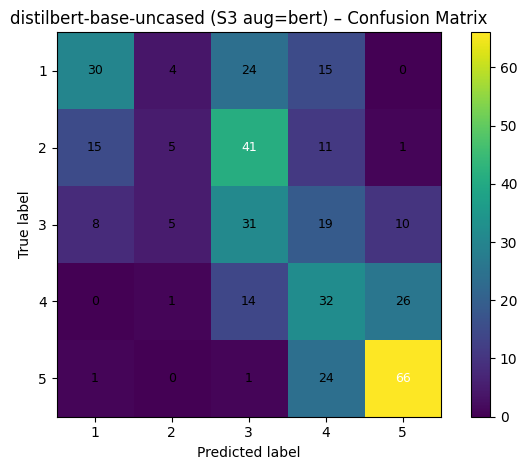

=== distilbert-base-uncased (S3 aug=bert) ===
{'eval_loss': 1.6368783712387085, 'eval_accuracy': 0.4270833333333333, 'eval_f1_macro': 0.3935545998268967, 'eval_f1_weighted': 0.40757543593321816, 'eval_runtime': 2.0211, 'eval_samples_per_second': 189.996, 'eval_steps_per_second': 11.875, 'epoch': 3.0}


------------------------------------------------------------
S3 | Transformers | Strategy: backtranslation
Train dist: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

/tmp/ipykernel_55/2167427641.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.209600,1.290849,0.434896,0.414910,0.428080
2,0.682500,1.730495,0.406250,0.347768,0.364944


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Confusion Matrix for bert-base-uncased (S3 aug=backtranslation)


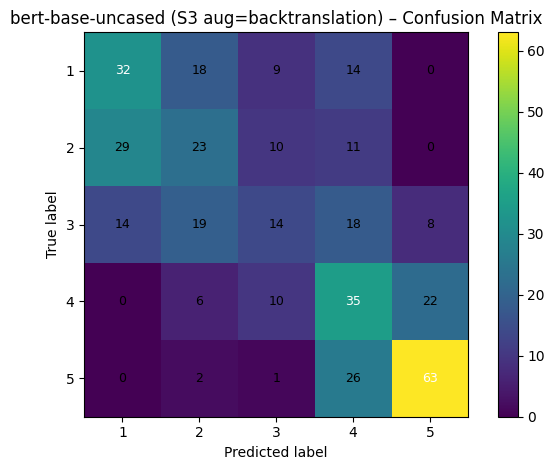

=== bert-base-uncased (S3 aug=backtranslation) ===
{'eval_loss': 1.2908488512039185, 'eval_accuracy': 0.4348958333333333, 'eval_f1_macro': 0.4149102227140453, 'eval_f1_weighted': 0.4280801349769976, 'eval_runtime': 4.1417, 'eval_samples_per_second': 92.716, 'eval_steps_per_second': 5.795, 'epoch': 2.0}



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

/tmp/ipykernel_55/2167427641.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.272200,1.328928,0.406250,0.375782,0.390516
2,0.808800,1.508545,0.419271,0.407788,0.418570
3,0.523300,1.772889,0.406250,0.386864,0.397000


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Confusion Matrix for distilbert-base-uncased (S3 aug=backtranslation)


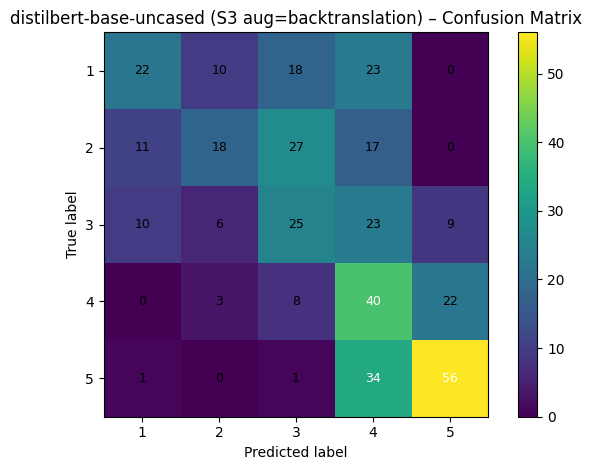

=== distilbert-base-uncased (S3 aug=backtranslation) ===
{'eval_loss': 1.508544921875, 'eval_accuracy': 0.4192708333333333, 'eval_f1_macro': 0.4077878353473766, 'eval_f1_weighted': 0.4185698647349403, 'eval_runtime': 2.0327, 'eval_samples_per_second': 188.911, 'eval_steps_per_second': 11.807, 'epoch': 3.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
0,bert-base-uncased (S3 aug=eda),0.390625,0.384021,0.389032,1.317031,2.0
1,distilbert-base-uncased (S3 aug=eda),0.427083,0.403683,0.415804,1.289612,2.0
2,bert-base-uncased (S3 aug=modified_eda),0.395833,0.373419,0.387750,2.023665,4.0
3,distilbert-base-uncased (S3 aug=modified_eda),0.419271,0.394985,0.408093,2.074457,5.0
4,bert-base-uncased (S3 aug=bert),0.414062,0.373809,0.387767,1.988621,4.0
5,distilbert-base-uncased (S3 aug=bert),0.427083,0.393555,0.407575,1.636878,3.0
6,bert-base-uncased (S3 aug=backtranslation),0.434896,0.414910,0.428080,1.290849,2.0
7,distilbert-base-uncased (S3 aug=backtranslation),0.419271,0.407788,0.418570,1.508545,3.0


In [51]:
def clean_tmp(prefix="./tmp_"):
    for d in glob.glob(prefix + "*"):
        shutil.rmtree(d, ignore_errors=True)

results_s3_tr = []

for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | Transformers | Strategy:", strat)
    clean_tmp()

    try:
        Xtr_aug, ytr_aug, _ = load_aug(strat)
        print("Train dist:", Counter(ytr_aug))

        # BERT
        bert_res = train_eval_transformer(
            "bert-base-uncased",
            Xtr_aug, ytr_aug, X_test_s3, y_test_s3,
            out_dir=f"./tmp_bert_s3_{strat}",
            suffix=f" (S3 aug={strat})",
            use_class_weights=True
        )
        results_s3_tr.append(bert_res)

        # DistilBERT
        distil_res = train_eval_transformer(
            "distilbert-base-uncased",
            Xtr_aug, ytr_aug, X_test_s3, y_test_s3,
            out_dir=f"./tmp_distil_s3_{strat}",
            suffix=f" (S3 aug={strat})",
            use_class_weights=True
        )
        results_s3_tr.append(distil_res)

    except Exception as e:
        print("S3 Transformer error:", strat, e)

s3_tr_table = pd.DataFrame(results_s3_tr)
s3_tr_table


# Summary


In [55]:
# Gabungkan S3 results
s3_table = pd.concat([s3_tfidf_table, s3_tr_table], ignore_index=True) if (len(results_s3) or len(results_s3_tr)) else pd.DataFrame()

def pick_cols(df_):
    cols = ["model", "accuracy", "f1_macro", "f1_weighted"]
    if "eval_loss" in df_.columns:
        cols.append("eval_loss")
    if "epoch" in df_.columns:
        cols.append("epoch")
    return df_[cols].copy()

s1_clean = pick_cols(s1_table) if "s1_table" in globals() else pd.DataFrame()
s2_clean = pick_cols(s2_table) if "s2_table" in globals() else pd.DataFrame()
s3_clean = pick_cols(s3_table) if not s3_table.empty else pd.DataFrame()

print("S1 (TF-IDF baseline):")
display(s1_clean.sort_values("f1_macro", ascending=False) if not s1_clean.empty else s1_clean)

print("\nS2 (Transformer baseline):")
display(s2_clean.sort_values("f1_macro", ascending=False) if not s2_clean.empty else s2_clean)

print("\nS3 (Aug from CSV):")
display(s3_clean.sort_values("f1_macro", ascending=False) if not s3_clean.empty else s3_clean)

summary = pd.concat([s1_clean, s2_clean, s3_clean], ignore_index=True) if not (s1_clean.empty and s2_clean.empty and s3_clean.empty) else pd.DataFrame()
summary = summary.sort_values("f1_macro", ascending=False) if not summary.empty else summary

print("\nSUMMARY (sorted by f1_macro):")
display(summary)


S1 (TF-IDF baseline):


,model,accuracy,f1_macro,f1_weighted
0,Linear SVM (S1 baseline),0.500000,0.375765,0.473433
2,Logistic Regression (S1 baseline),0.477273,0.239589,0.402541
1,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245



S2 (Transformer baseline):


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
0,bert-base-uncased (S2 baseline),0.536364,0.420316,0.533823,1.377648,6.0
1,distilbert-base-uncased (S2 baseline),0.563636,0.376724,0.535289,1.036261,4.0



S3 (Aug from CSV):


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
4,Naive Bayes (S3 aug=modified_eda),0.450521,0.446406,0.453738,NaN,NaN
7,Naive Bayes (S3 aug=bert),0.445312,0.442392,0.449864,NaN,NaN
1,Naive Bayes (S3 aug=eda),0.437500,0.429095,0.438469,NaN,NaN
18,bert-base-uncased (S3 aug=backtranslation),0.434896,0.414910,0.428080,1.290849,2.0
19,distilbert-base-uncased (S3 aug=backtranslation),0.419271,0.407788,0.418570,1.508545,3.0
2,Logistic Regression (S3 aug=eda),0.424479,0.407661,0.417975,NaN,NaN
13,distilbert-base-uncased (S3 aug=eda),0.427083,0.403683,0.415804,1.289612,2.0
15,distilbert-base-uncased (S3 aug=modified_eda),0.419271,0.394985,0.408093,2.074457,5.0
17,distilbert-base-uncased (S3 aug=bert),0.427083,0.393555,0.407575,1.636878,3.0
10,Naive Bayes (S3 aug=backtranslation),0.395833,0.393294,0.403358,NaN,NaN



SUMMARY (sorted by f1_macro):


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
9,Naive Bayes (S3 aug=modified_eda),0.450521,0.446406,0.453738,NaN,NaN
12,Naive Bayes (S3 aug=bert),0.445312,0.442392,0.449864,NaN,NaN
6,Naive Bayes (S3 aug=eda),0.437500,0.429095,0.438469,NaN,NaN
3,bert-base-uncased (S2 baseline),0.536364,0.420316,0.533823,1.377648,6.0
23,bert-base-uncased (S3 aug=backtranslation),0.434896,0.414910,0.428080,1.290849,2.0
24,distilbert-base-uncased (S3 aug=backtranslation),0.419271,0.407788,0.418570,1.508545,3.0
7,Logistic Regression (S3 aug=eda),0.424479,0.407661,0.417975,NaN,NaN
18,distilbert-base-uncased (S3 aug=eda),0.427083,0.403683,0.415804,1.289612,2.0
20,distilbert-base-uncased (S3 aug=modified_eda),0.419271,0.394985,0.408093,2.074457,5.0
22,distilbert-base-uncased (S3 aug=bert),0.427083,0.393555,0.407575,1.636878,3.0
